In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import mean_squared_error

data = pd.DataFrame()
path = 'CFRM521-ProjectData-main/filtered'
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        name = path + '/' + filename
        df = pd.read_csv(name)
        data = pd.concat([data, df], ignore_index=True)

In [2]:
height, width = data.shape

test_train_split = int(height * 0.8) # 80-20 train-test split
valid_train_split = int(test_train_split * 0.8) # 80-20 train-valid split

X_data = data[:test_train_split]

train_data = X_data[:valid_train_split]
valid_data = X_data[valid_train_split:]
test_data = data[test_train_split:]

def define_features(df):
    X = df[['close', 'strike', 'delta', 'gamma', 'vega', 'theta', 'implied_volatility']]
    y = df['mid_price']
    return X, y

X_train, y_train = define_features(train_data)
X_valid, y_valid = define_features(valid_data)
X_test, y_test = define_features(test_data)

## Gradient Boost

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

gbrt = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=120,
                                 learning_rate=0.1,
                                 n_iter_no_change=10,
                                 random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 22.13481321709718
Mean absolute error of test set: 2.1296734047126176


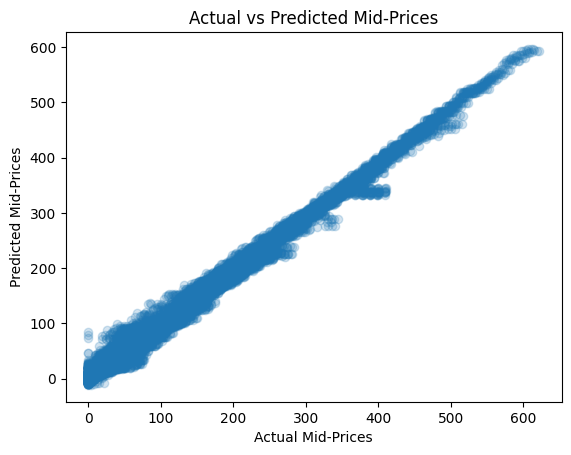

In [6]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

## Hyperparameter search

In [8]:
for l in (0.1, 0.3, 0.5, 0.7, 1.0):
    gbrt = GradientBoostingRegressor(
        max_depth=5, learning_rate=l,
        n_estimators=120, random_state=42
    )
    gbrt.fit(X_train, y_train)

    gbrt.staged_predict(X_valid)
    errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    best_MSE = np.min(errors)
    best_MAE = np.min(errs)
    print()
    print(f'Learning rate: {l}')
    best_n_estimators = np.argmin(errors)+1
    best_n_est = np.argmin(errs)+1
    print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
    print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.1
min MSE: 21.1644, number of trees: 120
min MAE: 2.1518, number of trees: 120

Learning rate: 0.3
min MSE: 12.5760, number of trees: 120
min MAE: 1.7065, number of trees: 120

Learning rate: 0.5
min MSE: 13.3060, number of trees: 120
min MAE: 1.7966, number of trees: 120

Learning rate: 0.7
min MSE: 15.9642, number of trees: 120
min MAE: 1.9238, number of trees: 120

Learning rate: 1.0
min MSE: 27.1248, number of trees: 120
min MAE: 2.2939, number of trees: 120


Learning rate 0.5 has the smallest MSE and MAE, and as such, is the learning rate that will be used going forward. Now, we want to find the ideal number of 

In [10]:
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 learning_rate=0.5,
                                 n_estimators=500, 
                                 n_iter_no_change=10,
                                 random_state=42)
gbrt.fit(X_train, y_train)

gbrt.staged_predict(X_valid)



errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
best_MSE = np.min(errors)
best_MAE = np.min(errs)
print()
print(f'Learning rate: {l}')
best_n_estimators = np.argmin(errors)+1
best_n_est = np.argmin(errs)+1
print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 1.0
min MSE: 8.8596, number of trees: 494
min MAE: 1.2843, number of trees: 500


## Best Model

In [12]:
best_model = GradientBoostingRegressor(max_depth=5, 
                                       learning_rate=0.5,
                                       n_estimators=476, 
                                       random_state=42)
gbrt.fit(X_train, y_train)

y_pred = gbrt.predict(X_test)


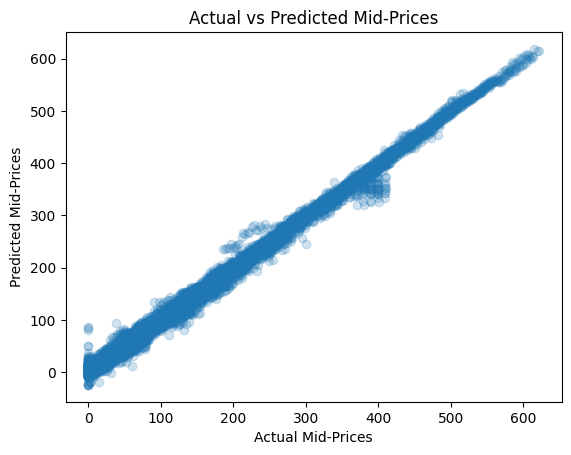

In [13]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

In [14]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 8.623880315690087
Mean absolute error of test set: 1.2622050244266165
